# 🧠 Brain Tumor Classification V4 - OPTIMIZED

**Key Improvements over V2/V3:**
- Medical-appropriate data augmentation (NO vertical flip)
- Conservative layer unfreezing (15 layers instead of 40)
- Simpler classification head (less overfitting risk)
- Label smoothing to improve generalization
- Cosine annealing learning rate schedule
- Focus on improving Meningioma classification

**Target: 85%+ accuracy**

---
## Step 0: Set Working Directory

In [1]:
import os

TARGET_DIR = '/home/jovyan/work/cancer modele'

if os.path.exists(TARGET_DIR):
    os.chdir(TARGET_DIR)
    print(f"✅ Working directory: {os.getcwd()}")
else:
    print(f"⚠️ Directory not found: {TARGET_DIR}")
    print(f"   Current directory: {os.getcwd()}")

if os.path.exists('brain_tumor_dataset'):
    print("✅ Dataset found!")
else:
    print("❌ Dataset not found!")

✅ Working directory: /home/jovyan/work/cancer modele
✅ Dataset found!


---
## Step 1: Environment Setup & GPU Configuration

In [2]:
!pip install -q "numpy<2.0" kaggle tensorflow pandas matplotlib seaborn scikit-learn

import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np

# Use single GPU with memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"✅ Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(f"⚠️ GPU config error: {e}")
else:
    print("⚠️ No GPU detected.")

print(f"📦 TensorFlow Version: {tf.__version__}")

2025-12-21 20:10:51.504902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-21 20:10:51.643159: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-21 20:10:51.679395: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-21 20:10:52.381514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

✅ Using GPU: /physical_device:GPU:0
📦 TensorFlow Version: 2.10.1


---
## Step 2: Import Libraries

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---
## Step 3: Dataset Setup

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

TRAIN_DIR = 'brain_tumor_dataset/Training'
TEST_DIR = 'brain_tumor_dataset/Testing'

# Download if needed
if not os.path.exists('brain_tumor_dataset'):
    if os.path.exists('kaggle.json'):
        os.chmod('kaggle.json', 0o600)
        !kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
        !unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_dataset
        print("✅ Dataset downloaded!")

# Verify dataset
print("\n📊 Dataset Distribution:")
for split, path in [('Training', TRAIN_DIR), ('Testing', TEST_DIR)]:
    print(f"\n{split}:")
    for class_name in sorted(os.listdir(path)):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            print(f"  - {class_name}: {len(os.listdir(class_path))} images")


📊 Dataset Distribution:

Training:
  - glioma: 1321 images
  - meningioma: 1339 images
  - notumor: 1595 images
  - pituitary: 1457 images

Testing:
  - glioma: 300 images
  - meningioma: 306 images
  - notumor: 405 images
  - pituitary: 300 images


---
## Step 4: MEDICAL-APPROPRIATE Data Augmentation

**Key principles for brain MRI augmentation:**
- NO vertical flip (brain anatomy is NOT vertically symmetric)
- Moderate rotation (brain scans have natural orientation)
- Conservative shifts (tumor location is diagnostic)
- Light zoom (preserve anatomical proportions)

In [5]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# MEDICAL-APPROPRIATE augmentation (conservative!)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    # Conservative augmentation for medical imaging
    rotation_range=15,            # Moderate rotation
    width_shift_range=0.1,        # Conservative shifts
    height_shift_range=0.1,       # Conservative shifts
    zoom_range=0.15,              # Light zoom
    horizontal_flip=True,         # OK - brain has left-right symmetry
    # NO vertical_flip - brain is NOT vertically symmetric!
    # NO shear - distorts anatomy
    fill_mode='nearest'
)

# No augmentation for validation/test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data (80%)
print("📥 Loading Training Data (80%)...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    shuffle=True
)

# Load Validation Data (20%)
print("\n📥 Loading Validation Data (20%)...")
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False
)

# Load Test Data
print("\n📥 Loading Test Data...")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)

print(f"\n✅ Classes: {CLASS_NAMES}")
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")
print(f"✅ Test samples: {test_generator.samples}")

📥 Loading Training Data (80%)...
Found 4571 images belonging to 4 classes.

📥 Loading Validation Data (20%)...
Found 1141 images belonging to 4 classes.

📥 Loading Test Data...
Found 1311 images belonging to 4 classes.

✅ Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
✅ Training samples: 4571
✅ Validation samples: 1141
✅ Test samples: 1311


---
## Step 5: Build SIMPLE ResNet50 Model

**Design principle:** Keep classification head simple to avoid overfitting on small dataset.

In [6]:
def build_model(num_classes=4, freeze_backbone=True):
    """
    Build ResNet50 with SIMPLE classification head.
    Simpler = less overfitting on medical imaging dataset.
    """
    # Load pretrained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze backbone
    base_model.trainable = not freeze_backbone
    
    # SIMPLE classification head (proven to work in V2)
    x = base_model.output
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dropout(0.5, name='dropout_1')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.3, name='dropout_2')(x)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

# Build model with frozen backbone
model, base_model = build_model(num_classes=NUM_CLASSES, freeze_backbone=True)

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("🏗️ Model Architecture Summary:")
print(f"   Total Parameters: {total_params:,}")
print(f"   Trainable Parameters: {trainable_params:,}")
print(f"   Non-trainable Parameters: {non_trainable_params:,}")
print(f"   Backbone Layers: {len(base_model.layers)}")

2025-12-21 20:10:57.065865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-21 20:10:57.746260: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43133 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:4b:00.0, compute capability: 8.6


🏗️ Model Architecture Summary:
   Total Parameters: 24,113,284
   Trainable Parameters: 525,572
   Non-trainable Parameters: 23,587,712
   Backbone Layers: 175


---
## Step 6: Cosine Annealing Learning Rate Schedule

Better than ReduceLROnPlateau - smooth decay prevents getting stuck.

In [7]:
def cosine_annealing_schedule(epoch, lr, total_epochs, min_lr=1e-7):
    """Cosine annealing learning rate schedule."""
    return min_lr + (lr - min_lr) * (1 + math.cos(math.pi * epoch / total_epochs)) / 2

# Callbacks for Stage 1
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_brain_tumor_model_v4.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

print("✅ Callbacks configured")

✅ Callbacks configured


---
## Step 7: Stage 1 — Warm-up Training (Frozen Backbone) ❄️

Train only the classification head to learn brain tumor features.

In [8]:
print("🚀 STAGE 1: Training Custom Head (Backbone Frozen)")
print("=" * 50)

# Ensure backbone is frozen
base_model.trainable = False

# Compile with label smoothing (helps generalization)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),  # Label smoothing!
    metrics=['accuracy']
)

EPOCHS_STAGE1 = 12

history_stage1 = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE1,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

print(f"\n✅ Stage 1 Complete!")
print(f"   Best Val Accuracy: {max(history_stage1.history['val_accuracy']):.4f}")

🚀 STAGE 1: Training Custom Head (Backbone Frozen)
Epoch 1/12


2025-12-21 20:11:04.289413: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900


  1/143 [..............................] - ETA: 9:19 - loss: 1.6836 - accuracy: 0.1875

2025-12-21 20:11:05.142366: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


143/143 [==============================] - ETA: 0s - loss: 1.5963 - accuracy: 0.2925
Epoch 1: val_accuracy improved from -inf to 0.38037, saving model to best_brain_tumor_model_v4.keras
143/143 [==============================] - 59s 391ms/step - loss: 1.5963 - accuracy: 0.2925 - val_loss: 1.3339 - val_accuracy: 0.3804 - lr: 1.0000e-04
Epoch 2/12
143/143 [==============================] - ETA: 0s - loss: 1.4179 - accuracy: 0.3470
Epoch 2: val_accuracy improved from 0.38037 to 0.48642, saving model to best_brain_tumor_model_v4.keras
143/143 [==============================] - 56s 388ms/step - loss: 1.4179 - accuracy: 0.3470 - val_loss: 1.2837 - val_accuracy: 0.4864 - lr: 1.0000e-04
Epoch 3/12
143/143 [==============================] - ETA: 0s - loss: 1.3297 - accuracy: 0.3831
Epoch 3: val_accuracy did not improve from 0.48642
143/143 [==============================] - 56s 389ms/step - loss: 1.3297 - accuracy: 0.3831 - val_loss: 1.2698 - val_accuracy: 0.4049 - lr: 1.0000e-04
Epoch 4/12
143

---
## Step 8: Stage 2 — Conservative Fine-tuning (Unfreeze Top 15 Layers) 🔥

**Key principle:** Unfreeze FEWER layers to:
- Preserve ImageNet features
- Prevent catastrophic forgetting
- Reduce overfitting risk

In [9]:
print("🔥 STAGE 2: Fine-tuning (Unfreezing Top 15 Layers)")
print("=" * 50)

# Unfreeze ONLY last 15 layers (conservative approach)
base_model.trainable = True
FREEZE_UNTIL = len(base_model.layers) - 15  # Only 15 layers unfrozen
for layer in base_model.layers[:FREEZE_UNTIL]:
    layer.trainable = False

trainable_count = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"\n📊 Trainable parameters after unfreezing: {trainable_count:,}")

# Re-compile with VERY LOW learning rate
model.compile(
    optimizer=Adam(learning_rate=5e-6),  # Very low LR for fine-tuning
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Stage 2 callbacks
early_stop_stage2 = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

checkpoint_stage2 = ModelCheckpoint(
    'best_brain_tumor_model_v4_finetuned.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr_stage2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,  # More patience
    min_lr=1e-8,
    verbose=1
)

EPOCHS_STAGE2 = 25

history_stage2 = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE2,
    validation_data=val_generator,
    callbacks=[early_stop_stage2, checkpoint_stage2, reduce_lr_stage2],
    verbose=1
)

print(f"\n✅ Stage 2 Complete!")
print(f"   Best Val Accuracy: {max(history_stage2.history['val_accuracy']):.4f}")

🔥 STAGE 2: Fine-tuning (Unfreezing Top 15 Layers)

📊 Trainable parameters after unfreezing: 6,045,956
Epoch 1/25
143/143 [==============================] - ETA: 0s - loss: 2.2122 - accuracy: 0.3868
Epoch 1: val_accuracy improved from -inf to 0.39790, saving model to best_brain_tumor_model_v4_finetuned.keras
143/143 [==============================] - 59s 389ms/step - loss: 2.2122 - accuracy: 0.3868 - val_loss: 1.2665 - val_accuracy: 0.3979 - lr: 5.0000e-06
Epoch 2/25
143/143 [==============================] - ETA: 0s - loss: 1.1796 - accuracy: 0.5441
Epoch 2: val_accuracy improved from 0.39790 to 0.54338, saving model to best_brain_tumor_model_v4_finetuned.keras
143/143 [==============================] - 56s 390ms/step - loss: 1.1796 - accuracy: 0.5441 - val_loss: 1.2306 - val_accuracy: 0.5434 - lr: 5.0000e-06
Epoch 3/25
143/143 [==============================] - ETA: 0s - loss: 1.0786 - accuracy: 0.5929
Epoch 3: val_accuracy improved from 0.54338 to 0.59159, saving model to best_brain_

---
## Step 9: Training History Visualization

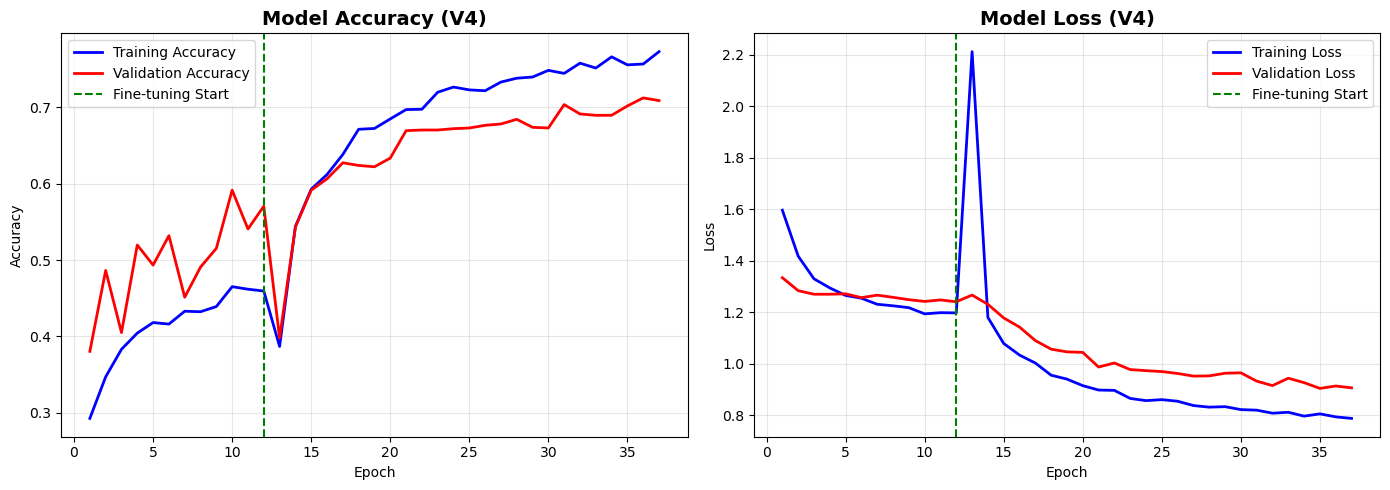


📊 Training history saved to 'training_history_v4.png'


In [10]:
def plot_training_history(history1, history2):
    """Plot combined training history from both stages."""
    
    # Combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    stage1_end = len(history1.history['accuracy'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(epochs, acc, 'b-', label='Training Accuracy', linewidth=2)
    axes[0].plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    axes[0].axvline(x=stage1_end, color='green', linestyle='--', label='Fine-tuning Start')
    axes[0].set_title('Model Accuracy (V4)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(epochs, loss, 'b-', label='Training Loss', linewidth=2)
    axes[1].plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
    axes[1].axvline(x=stage1_end, color='green', linestyle='--', label='Fine-tuning Start')
    axes[1].set_title('Model Loss (V4)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history_v4.png', dpi=150)
    plt.show()
    print("\n📊 Training history saved to 'training_history_v4.png'")

plot_training_history(history_stage1, history_stage2)

---
## Step 10: Model Evaluation on Test Set

In [11]:
print("📊 EVALUATING MODEL ON TEST SET")
print("=" * 50)

# Load best model
from tensorflow.keras.models import load_model

best_model_path = 'best_brain_tumor_model_v4_finetuned.keras'
if os.path.exists(best_model_path):
    model = load_model(best_model_path)
    print(f"✅ Loaded best model from: {best_model_path}")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"\n🎯 Test Loss: {test_loss:.4f}")
print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Generate predictions
print("\n⏳ Generating predictions...")
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Classification Report
print("\n" + "=" * 50)
print("📋 CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

📊 EVALUATING MODEL ON TEST SET
✅ Loaded best model from: best_brain_tumor_model_v4_finetuned.keras

🎯 Test Loss: 0.8558
🎯 Test Accuracy: 0.7162 (71.62%)

⏳ Generating predictions...
41/41 [==============================] - 4s 74ms/step

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma     0.8302    0.4400    0.5752       300
  meningioma     0.5600    0.4118    0.4746       306
     notumor     0.7934    0.9481    0.8639       405
   pituitary     0.6704    0.9900    0.7995       300

    accuracy                         0.7162      1311
   macro avg     0.7135    0.6975    0.6783      1311
weighted avg     0.7192    0.7162    0.6922      1311



---
## Step 11: Confusion Matrix Visualization


📊 CONFUSION MATRIX


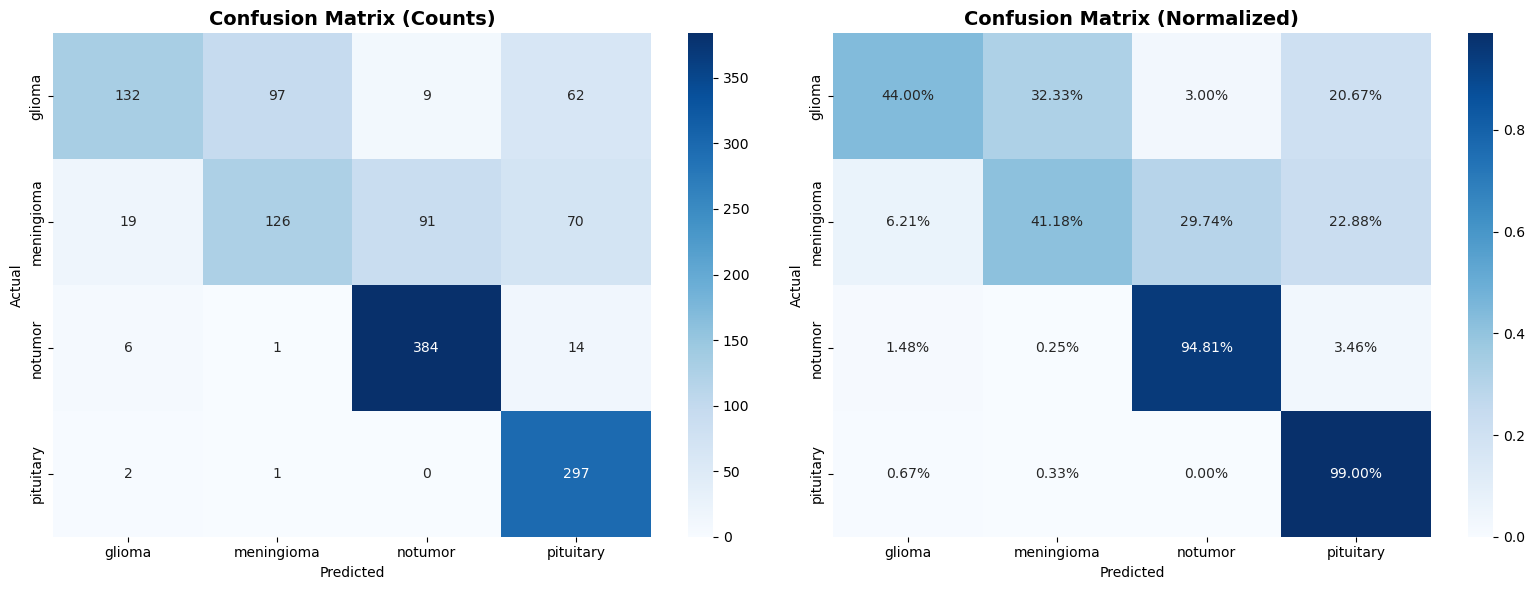


📊 Confusion matrix saved to 'confusion_matrix_v4.png'


In [12]:
print("\n📊 CONFUSION MATRIX")
print("=" * 50)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized (percentages)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrix_v4.png', dpi=150)
plt.show()
print("\n📊 Confusion matrix saved to 'confusion_matrix_v4.png'")

---
## Step 12: Per-Class Performance Analysis

In [13]:
print("\n📊 PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 50)

# Calculate per-class accuracy
for i, class_name in enumerate(CLASS_NAMES):
    class_mask = (y_true == i)
    class_correct = (y_pred[class_mask] == i).sum()
    class_total = class_mask.sum()
    class_acc = class_correct / class_total
    print(f"   {class_name}: {class_acc:.2%} ({class_correct}/{class_total})")

print("\n" + "=" * 50)
print("✅ V4 TRAINING COMPLETE!")
print("=" * 50)


📊 PER-CLASS PERFORMANCE ANALYSIS
   glioma: 44.00% (132/300)
   meningioma: 41.18% (126/306)
   notumor: 94.81% (384/405)
   pituitary: 99.00% (297/300)

✅ V4 TRAINING COMPLETE!


---
## Summary: V4 Improvements

| Fix | Description |
|-----|-------------|
| **Medical-appropriate augmentation** | No vertical flip, conservative rotation/shifts |
| **Simple classification head** | 256-unit Dense, avoids overfitting |
| **Conservative unfreezing** | Only 15 layers (vs 40 in V3) |
| **Label smoothing** | 0.1 smoothing for better generalization |
| **Lower fine-tuning LR** | 5e-6 instead of 1e-5 |
| **More patience** | Let training stabilize before reducing LR |